# COMP-4360 - Machine Learning - Project

Student Name: Xiaoran Xie

## Project specification

Implement a standard echo state network (ESN) model as discussed in class. Do not include feedback from the output and do not use leaky-integrator neurons. Implement training of the read-out weights by means of ridge regression. Perform experiments and comment the results by considering a _k_ step ahead forecasting task on the "2sine" and "lorentz" time series data provided to you together with this notebook. Evaluate the impact of relevant hyper-parameters on the results, including the reservoir size and the amount of training data used for optimizing the read-out weights. Finally, discuss the effects of using different forecasting horizons on the overall performance of the model. **Note:** it is possible to consider the impact of additional hyperparameters, like the spectral radius of the reservoir matrix, and this will give you some extra points.

### K step ahead forecasting
A _k_ step ahead forecasting task consists of predicting the value of a time series at time $t+k$ by using the value of the time series at time $t$, where $k\geq1$ is called forecasting horizon.
In general, the predicted value is always unidimensional (i.e. a single number). However, it is possible to use multiple input values in order to improve the results. Notably, once _k_ is decided, the output to be predicted is the value of the time series at time $t+k$, and the input may be a vector containing values of the times series at time $t, t-1, \dots, t-n$, where $n\geq0$ is defined by the user and sets the dimensionality of the input vector.

---
## Construct ESN class and functions
Import required packages, make sure current environment has matplotlib and numpy packages<br>

In [691]:
# make sure current environment has matplotlib package
import matplotlib.pyplot as plt
# make sure current environment has numpy package
import numpy as np
# make sure plots are correctly displayed in the notebook
%matplotlib inline

Read dataset, there are two .txt files in folder which are 2sin.txt and lorenz.txt<br>
The following func is aim to load one dataset and return it as array

In [692]:
def read_dataset(datasetName):
    dataset = np.loadtxt(datasetName)
    #print(dataset)
    return dataset

The following class is aim to construct echo state network, including five methods
1. constructor()
receive N_i, N_r, N_o as parameter, intialize W_i, W_r, W_o<br>
2. reservoirs()
train ESN by training set, collect states x and save them in matrix X, return X<br>
3. ridgeRegression()
calculate read-out weights W_o by means of ridge regression, return W_o<br>
4. predict()
put read-out weights W_o back to network, run ESN by testing set, use k-step ahead forecasting to get outputs<br>
5. calculateError()
calculate mean square error<br>

More details about method parameters and attributes i left in the comments.

In [693]:
class ESN:
    """
        __init__(self, N_i, N_r, N_o)
        
        args:
            N_i (int): input dimension
            N_r (int): the number of neurons in the recurrent layer(number of reservoirs)
            N_o (int): dimension of outputs
            
        attributes:
            N_i (int): input dimension
            N_r (int): the number of neurons in the recurrent layer(number of reservoirs)
            N_o (int): dimension of outputs
            W_r (np.array matrix): recurrent layer weight matrix, [N_r x N_r]
            W_i (np.array matrix): input-to-reservoir weight matrix, [N_r x N_i]
            W_o (np.array matrix): read-output weight matrix, [N_o x N_r]
    """
    def __init__(self, N_i, N_r, N_o):   
        self.N_i = N_i
        self.N_r = N_r
        self.N_o = N_o
        # output key attributes
        #print("N_i: \n{}".format(self.N_i))
        #print("N_r: \n{}".format(self.N_r))
        #print("N_o: \n{}".format(self.N_o))
        
        # W_i belongs to [N_r x N_i], drawn from a uniform distribution in [−1, 1]
        self.W_i = np.random.uniform(-1, 1, (self.N_r, self.N_i))
        
        # W_r belongs to [N_r x N_r], drawn from a uniform distribution in [−1, 1],
        # then calculate spectral radius
        self.W_r = np.random.uniform(-1, 1, (self.N_r, self.N_r))
        spectralRadius = np.max(np.abs(np.linalg.eigvals(self.W_r)))
        scalar_a = 0.8
        self.W_r = (self.W_r/spectralRadius)*scalar_a
        
        # W_o belongs to [N_o x N_r], 
        # typically obtained by solving a regularized least-square regression problem
        self.W_o = np.random.uniform(-1, 1, (self.N_o, self.N_r))
    
    """
        reservoirs(self, dataset, train_size)
        
        args:
            dataset (array): input dataset
            train_size (int): size of training set
            
        attributes:
            x (np.array matrix): the sequence of states, [N_r x N_i]
            X (np.array matrix): collect the resulting N states xi in a matrix X, [train_size x N_r]
            t (int): time-step t
            u (np.array matrix): element at timestep ti, called input, [1 x 1]
    """
    def reservoirs(self, dataset, train_size):
        x = np.zeros(( self.N_r, self.N_i ))
        X = np.zeros(( train_size, self.N_r ))
        
        # start to train ESN
        for t in range(train_size):
            u = np.array([[ dataset[t] ]])
            # standard ESN model:
            #
            #      x_ti = φ( W_r x_t(i-1) + W_i u )
            #      z_ti = W_o x_ti 
            #                       
            # select tanh as activation function
            # since we don't have W_o, we collect states x and save in matrix X first
            # implementation:
            x = np.tanh( np.dot(self.W_r, x) + np.dot(self.W_i, u) )
            # since x is [N_r x N_i], transpose it as [N_i x N_r], then save it in matrix X
            X[t,:] = x.T
            
        # output key attributes
        #print("X: \n{}".format(X))
        return X
    
    """
        ridgeRegression(self, dataset, train_size, X)
        
        args:
            dataset (array): input dataset
            train_size (int): size of training set
            X (np.array matrix): collect the resulting N states xi in a matrix X, [train_size x N_r]
            
        attributes:
            T (array): corresponding target
            lambta (int): regularization coefficient, lambda
            I (np.array matrix): identity matrix, [N_r x N_r]
            W (np.array matrix): ridge regression closed-form solution, [N_r x N_o]
            W_o (np.array matrix): read-output weight matrix, [N_o x N_r]
    """
    def ridgeRegression(self, dataset, train_size, X):
        T = dataset[:train_size]
        # set regularization coefficient
        lambta = 1e-7
        I = np.identity(self.N_r)
        
        # closed-form solution:
        #
        #      W = (XTX + λI)^(-1) XT t
        #
        # implementation:
        W = np.dot(np.dot( np.linalg.inv( np.dot(np.transpose(X), X) + lambta * I ), np.transpose(X) ), T)
        self.W_o = np.transpose(W)
        
        # output key attributes
        #print("W_o: \n{}".format(self.W_o))
        return self.W_o
    
    """
        predict(self, dataset, train_size, test_size, W_o, X)
        
        args:
            dataset (array): input dataset
            train_size (int): size of training set
            test_size (int): size of testing set
            W_o (np.array matrix): read-output weight matrix, [N_o x N_r]
            X (np.array): collect the resulting N states xi in a matrix X, [train_size x N_r]
            k (int): k of k-step ahead forecasting, output to be predicted is the value of the time series at time t+k
            
        attributes:
            W_o (np.array matrix): read-output weight matrix, [N_o x N_r]
            u (np.array matrix): element at timestep, called input, [1 x 1]
            x (np.array matrix): the sequence of states, [N_r x N_i]
            Z (np.array matrix): collect the resulting N states zi in a matrix Z, [N_o, test_size]
            z (np.array matrix): [N_o x N_i]
    """
    def predict(self, dataset, train_size, test_size, W_o, X, k, n):
        self.W_o = W_o
        u = np.array([[ dataset[train_size] ]])
        x = np.transpose( np.array([ X[train_size-1,:] ]) )
        Z = np.zeros([self.N_o, test_size+k])
        
        # run ESN and predict
        for t in range(test_size):
            # standard ESN model:
            #
            #      x_ti = φ( W_r x_t(i-1) + W_i u )
            #      z_ti = W_o x_ti 
            #                             
            # same as above method, select tanh as activation function
            # we already have W_o from ridgeRegression method, thus we can keep going on
            # implementation:
            x = np.tanh( np.dot(self.W_r, x) + np.dot(self.W_i, u) )
            z = np.dot( self.W_o, x )
            # by k-step ahead forecasting, jump k in testing set
            u = np.array([[ dataset[train_size+t+k] ]])
            Z[:, t] = z

        # output key attributes
        #print("Z:\n{}".format(Z))
        return Z
    
    """
        calculateError(self, dataset, train_size, error_size, Z):
        
        args:
            dataset (array): input dataset
            train_size (int): size of training set
            error_size (int): size of measurement error range
            Z (np.array matrix): collect the resulting N states zi in a matrix Z, [N_o, test_size]
            
        attributes:
            t_val : target value
            p_val : predicted value
            mse : mean square error
    """
    def calculateError(self, dataset, train_size, error_size, Z, k):
        t_val = dataset[ train_size+k : train_size+error_size+k ]
        #p_val = Z[0, 0:error_size+k]
        p_val = Z[0, :error_size]
        
        # mean-squared Error (MSE):
        #
        #      MSE = 〈‖t − z‖^2〉
        #
        # implementation:
        mse = sum( np.square( t_val - p_val ) )  / error_size
        
        # output key attributes
        print('MSE = {}'.format(str( mse )))
        return mse
              

Call this function to run ESN

In [694]:
def runESN(datasetName, N_i, N_r, N_o, train_size, test_size, error_size, k, n):
    """
    Load dataset
    """
    dataset = read_dataset(datasetName)
    
    """
    Initialize ESN with N_i, N_r, N_o, construct ESN
    """
    esn = ESN(N_i, N_r, N_o)
    
    """
    Set size of training set
    Then train ESN by training set and collect the resulting N states x into X
    """
    X = esn.reservoirs(dataset, train_size)
    
    """
    Calculate read-out weights W_o by means of ridge regression
    """
    W_o = esn.ridgeRegression(dataset, train_size, X)
    
    """
    After training ridge regression, get W_o, then put it back to ESN
    Run the trained ESN by testing set
    Collect output into Z by k-step ahead forecasting
    """
    Z = esn.predict(dataset, train_size, test_size, W_o, X, k, n)
    
    """
    Eventually, calculate mean square error
    """
    mse = esn.calculateError(dataset, train_size, error_size, Z, k)
    
    return dataset, X, W_o, Z, mse

Call this function to plot related diagrams

In [695]:
def plot_original(dataset):
    """
    Present original dataset
    """
    plt.figure(figsize=(15,4))
    plt.plot(dataset, 'red', linewidth=0.8)
    plt.title(r'Dataset')  

def plot_testing(train_size, test_size, Z):
    """
    Present targets and prediction outputs during testing process
    """
    plt.figure(figsize=(15,4))
    plt.plot(dataset[train_size+k:train_size+test_size+k], 'red', linewidth=2)
    plt.plot(Z.T, 'b', linewidth=0.8)
    plt.title(r'Targets and prediction outputs $\mathbf{Z}$')
    plt.legend(['Target', 'Prediction'])

def plot_states(X):
    """
    Present part of activation reservoirs states
    """
    plt.figure(figsize=(15,4))
    plt.plot(X[:400,:50])
    plt.title(r'Reservoirs states $\mathbf{x}(n)$')

def plot_Wo(N_r, W_o):
    """
    Present read-out weights during training process
    """
    plt.figure(figsize=(15,4))
    plt.bar( np.arange(N_r), W_o.T )
    plt.title(r'Read-out weights $\mathbf{W}^{out}$')

---
## Run ESN and present contents
After implementing ESN above, it's time to run ESN. Since there are two .txt files, i will present them separately
#### Load "2sin.txt", train ESN, predict output, calculate error
Default:

In [696]:
datasetName = "2sin.txt"
N_i = 1
N_r = 10
N_o = 1
train_size = 20
test_size = 800
error_size = 800
k = 1
n = 0
returnList = runESN(datasetName, N_i, N_r, N_o, train_size, test_size, error_size, k, n)[:]
dataset = returnList[0]
X = returnList[1]
W_o = returnList[2]
Z = returnList[3]
mse = returnList[4]

MSE = 0.06522593673462375


#### Plot diagram
The first diagram presents the original dataset<br>
The second diagram presents targets and prediction outputs during testing process. Red line is targets, blue line is prediction outputs<br>
The third diagram presents reservoirs states<br>
The Fourth diagram presents read-out weights

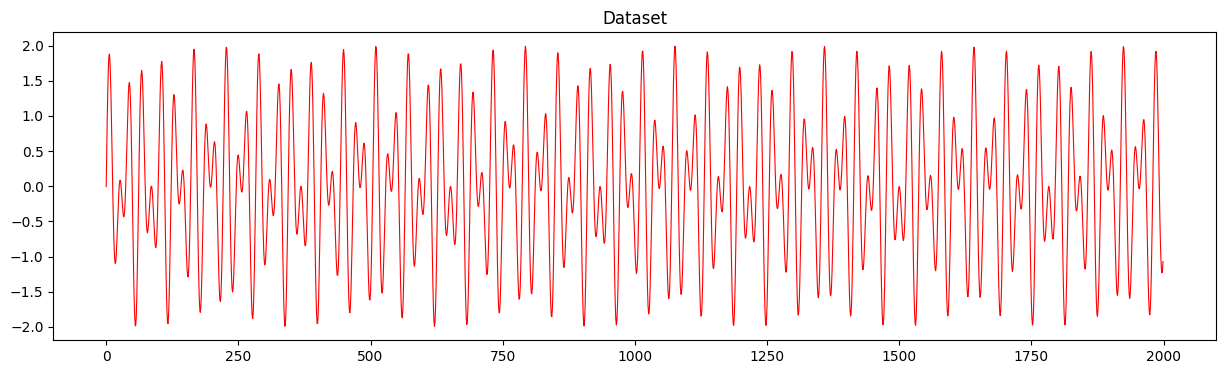

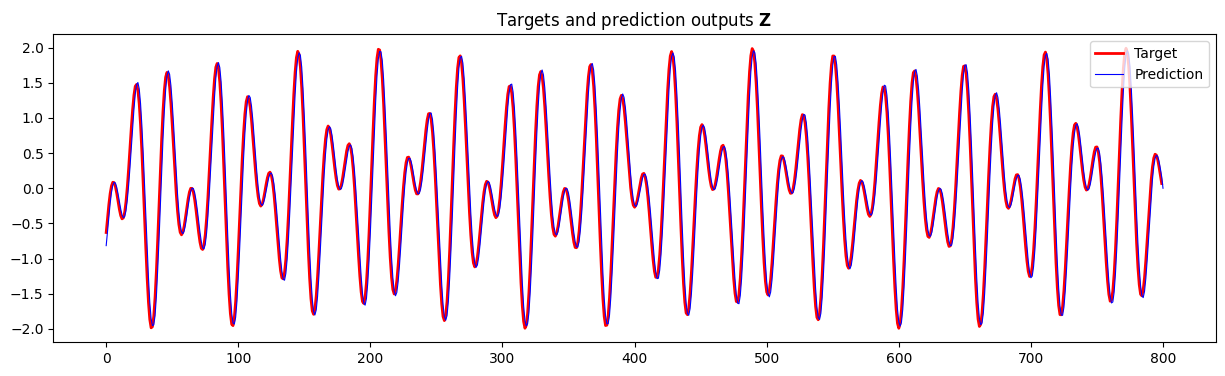

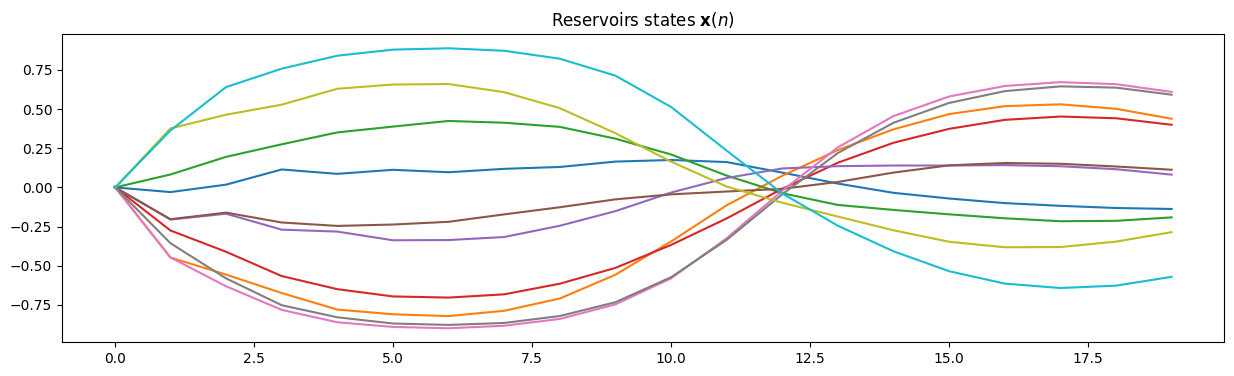

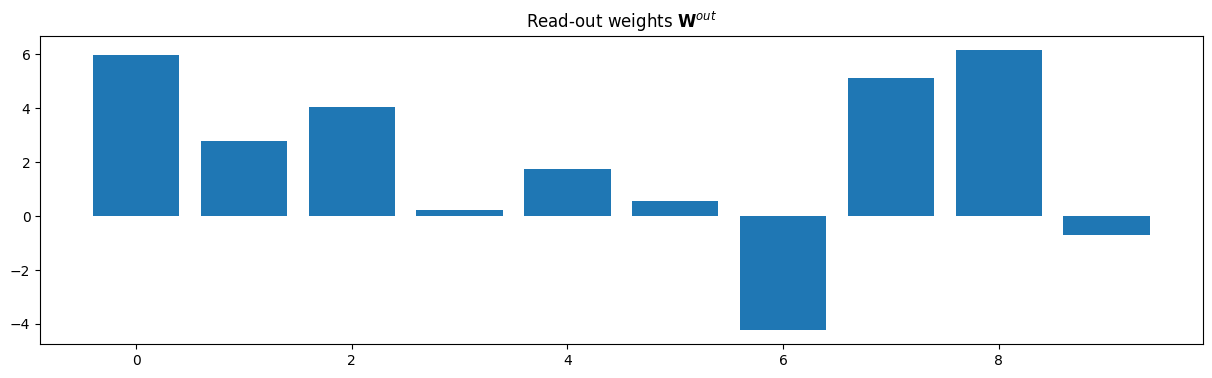

In [697]:
plot_original(dataset)
plot_testing(train_size, test_size, Z)
plot_states(X)
plot_Wo(N_r, W_o)

#### Impact of relevant hyper-parameters: reservoir size
In order to compare the effect of the number of reservoirs on the results, I will only change N_r in the following experiments<br>
- N_r = 3

MSE = 0.08175178508147657


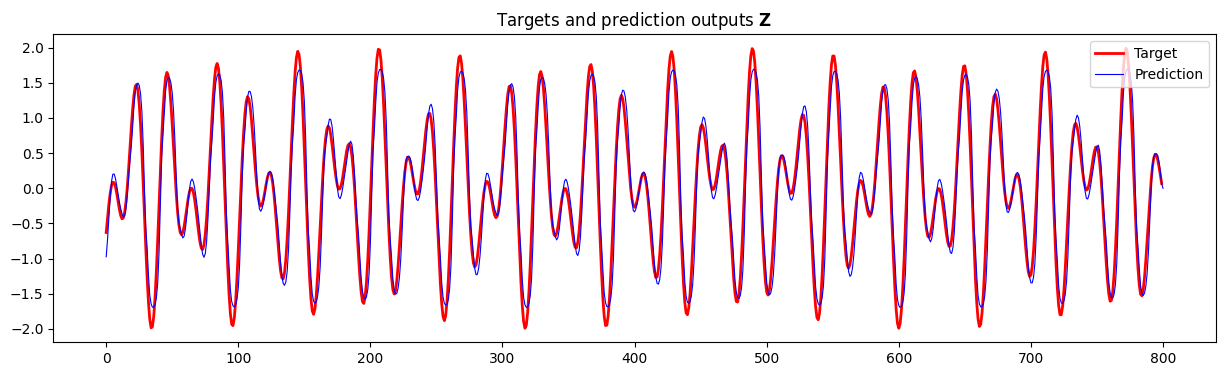

In [698]:
N_r = 3
returnList = runESN(datasetName, N_i, N_r, N_o, train_size, test_size, error_size, k, n)[:]
Z = returnList[3]
plot_testing(train_size, test_size, Z)

- N_r = 30

MSE = 0.06626547126706532


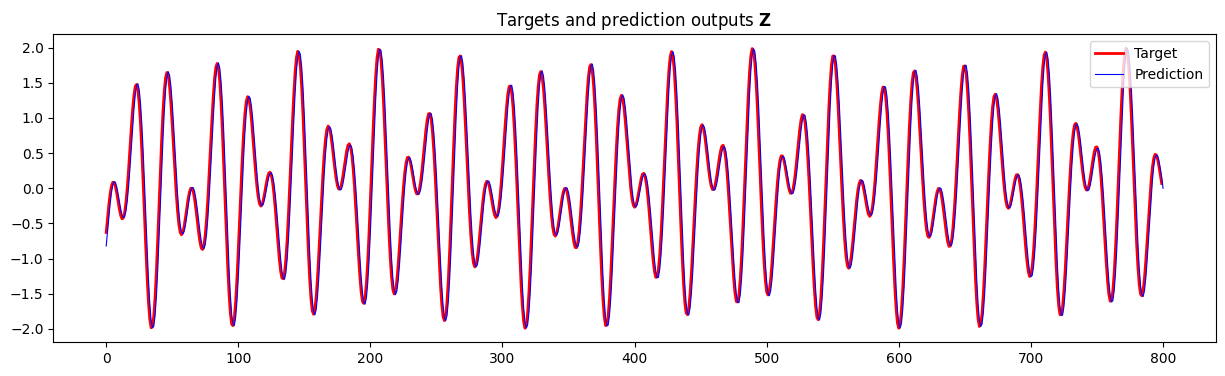

In [699]:
N_r = 30
returnList = runESN(datasetName, N_i, N_r, N_o, train_size, test_size, error_size, k, n)[:]
Z = returnList[3]
plot_testing(train_size, test_size, Z)

- N_r = 300

MSE = 0.06657338322277202


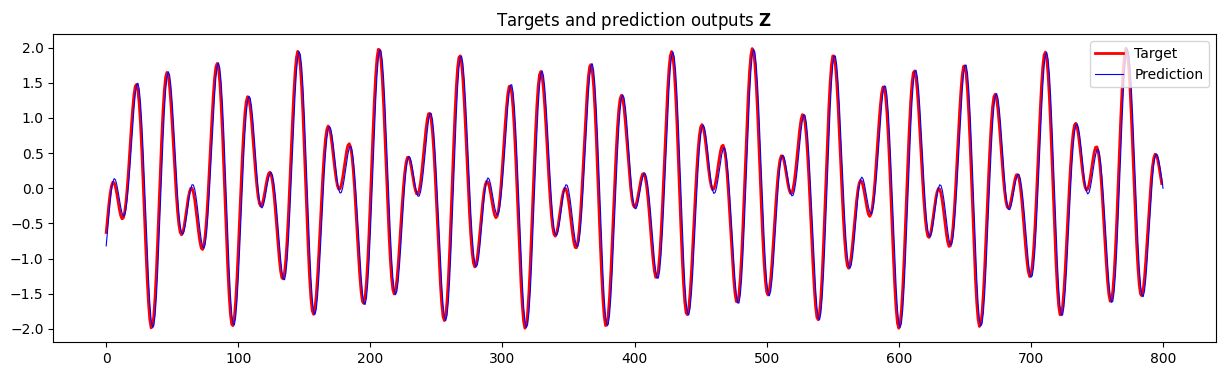

In [700]:
N_r = 300
returnList = runESN(datasetName, N_i, N_r, N_o, train_size, test_size, error_size, k, n)[:]
Z = returnList[3]
plot_testing(train_size, test_size, Z)

- N_r = 1000

MSE = 0.06747541413904898


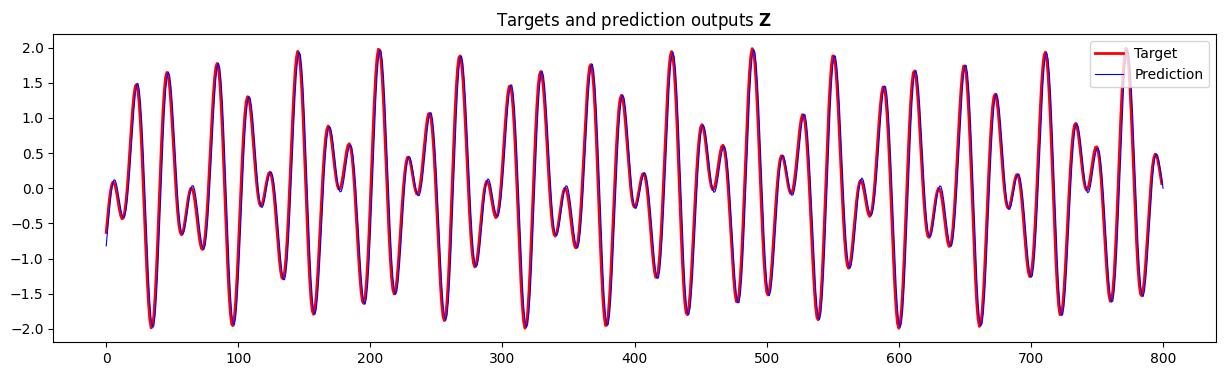

In [701]:
N_r = 1000
returnList = runESN(datasetName, N_i, N_r, N_o, train_size, test_size, error_size, k, n)[:]
Z = returnList[3]
plot_testing(train_size, test_size, Z)

In this experiment, as the number of reservoirs increases (3-30-300-1000), the prediction error becomes smaller and smaller. Therefore, I consider that an increase in the number of reservoirs will reduce the prediction error
#### Impact of relevant hyper-parameters: the amount of training data used for optimizing the read-out weights
In order to compare the effect of the amount of training data, I will only change train_size in the following experiments<br>
- train_size = 20

MSE = 0.06516665530773352


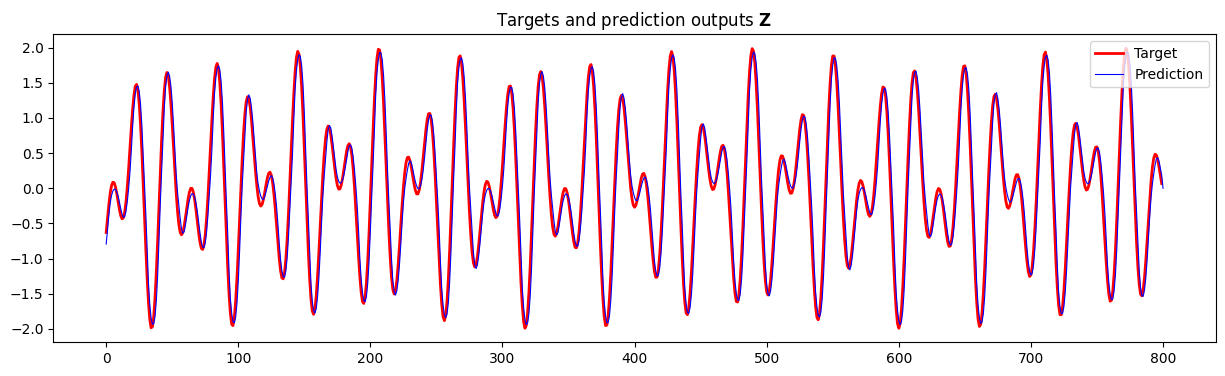

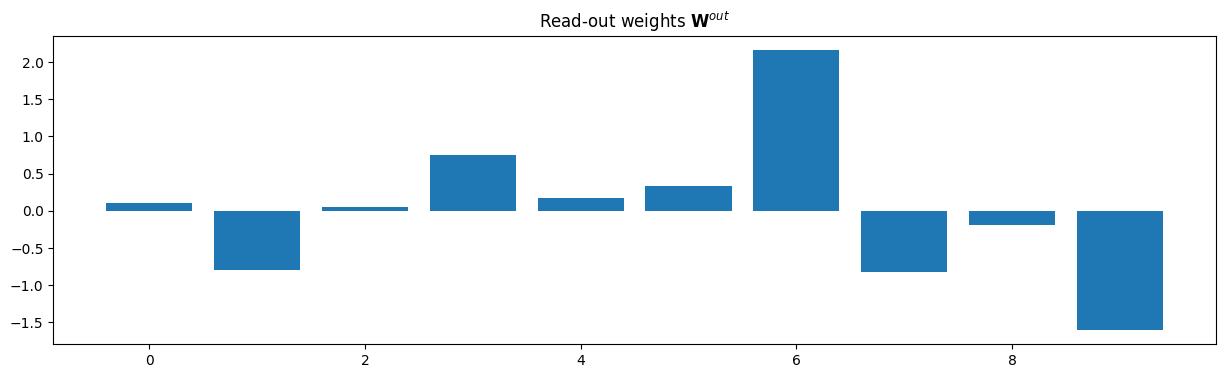

In [702]:
N_r = 10 # change N_r to default
train_size = 20
returnList = runESN(datasetName, N_i, N_r, N_o, train_size, test_size, error_size, k, n)[:]
W_o = returnList[2]
Z = returnList[3]
plot_testing(train_size, test_size, Z)
plot_Wo(N_r, W_o)

- train_size = 200

MSE = 0.06697861822648683


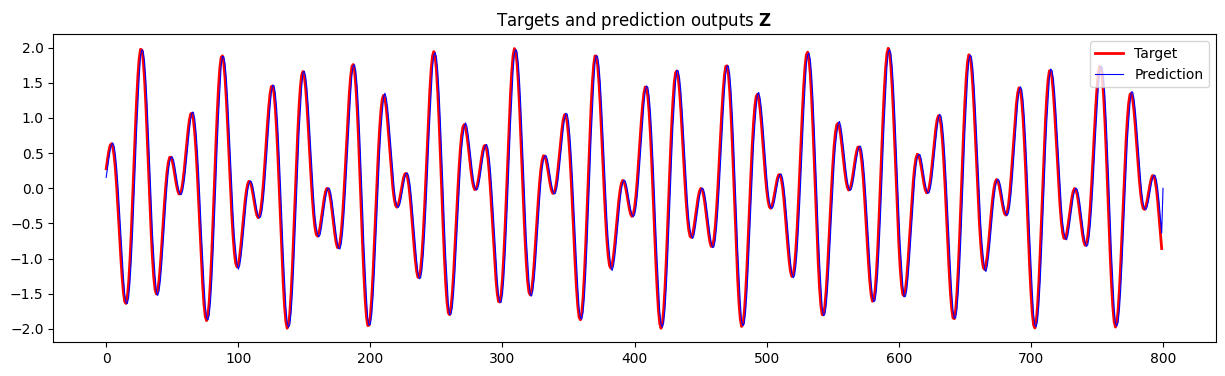

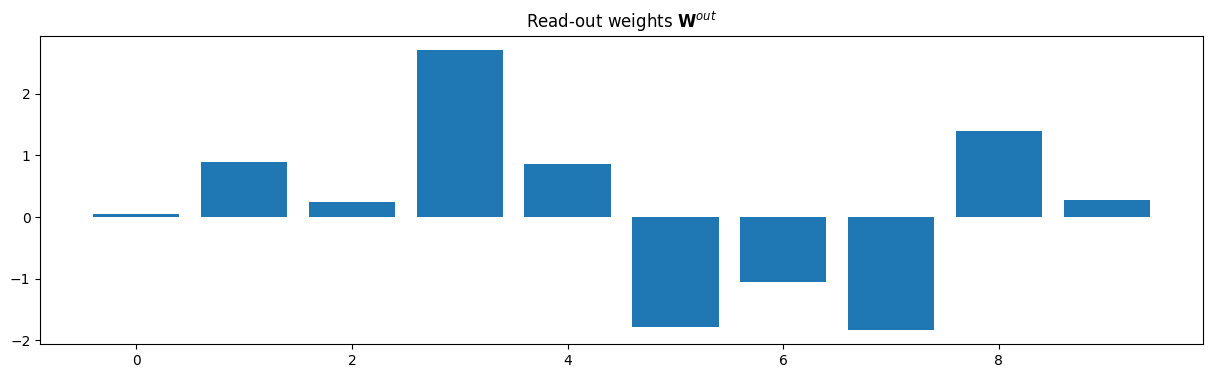

In [703]:
train_size = 200
returnList = runESN(datasetName, N_i, N_r, N_o, train_size, test_size, error_size, k, n)[:]
W_o = returnList[2]
Z = returnList[3]
plot_testing(train_size, test_size, Z)
plot_Wo(N_r, W_o)

- train_size = 400

MSE = 0.0681595890718658


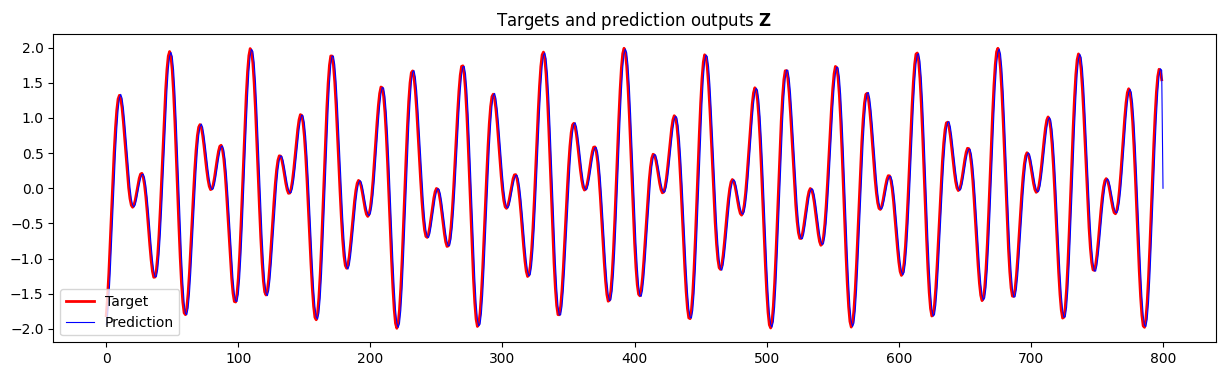

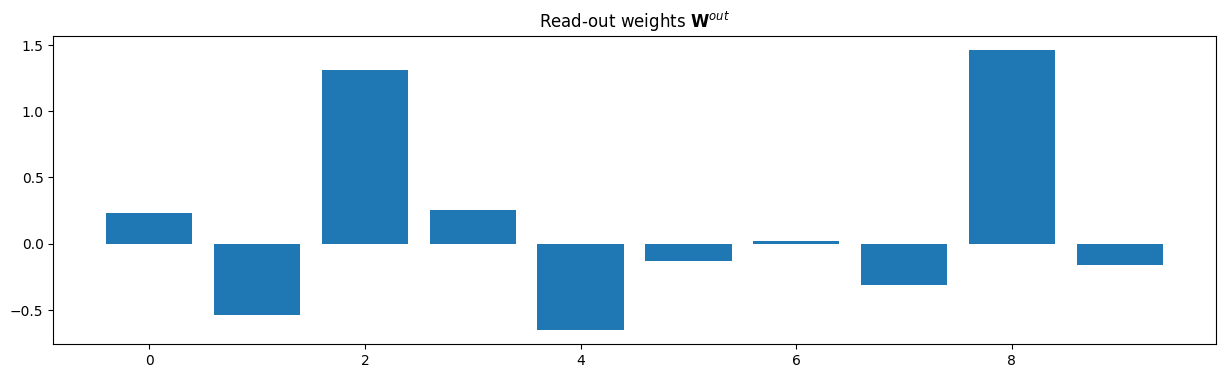

In [704]:
train_size = 400
returnList = runESN(datasetName, N_i, N_r, N_o, train_size, test_size, error_size, k, n)[:]
W_o = returnList[2]
Z = returnList[3]
plot_testing(train_size, test_size, Z)
plot_Wo(N_r, W_o)

- train_size = 600

MSE = 0.07061083913458838


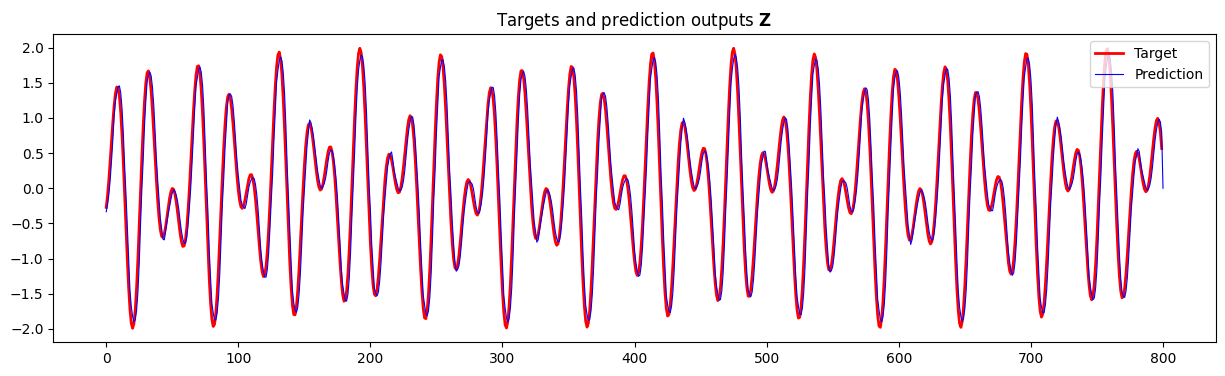

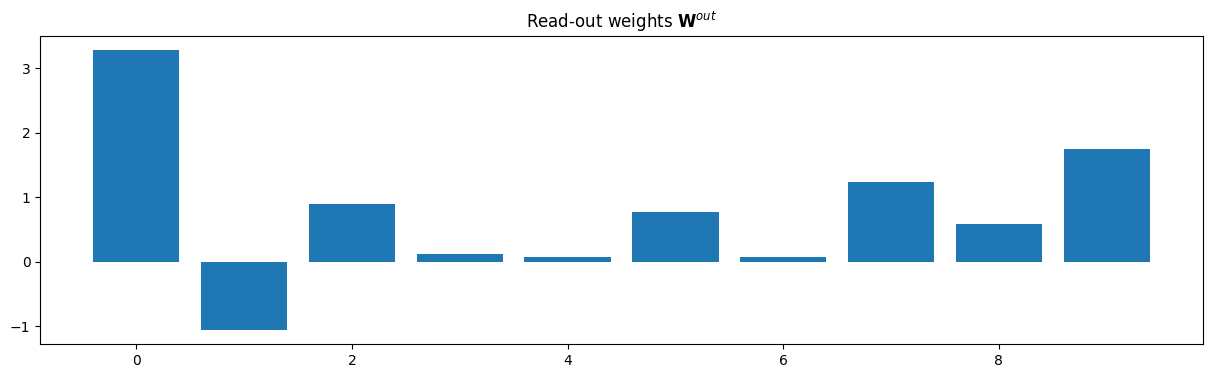

In [705]:
train_size = 600
returnList = runESN(datasetName, N_i, N_r, N_o, train_size, test_size, error_size, k, n)[:]
W_o = returnList[2]
Z = returnList[3]
plot_testing(train_size, test_size, Z)
plot_Wo(N_r, W_o)

In this experiment, as the size of training sets increases (20-200), the prediction error is decreasing. However, as the size of training sets continued to increase (400-600), the prediction error increased instead. Therefore, I consider that too large size of training set will lead to overfitting, which will reduce the accuracy of prediction and lead to an increase in error

#### Impact of relevant hyper-parameters: different forecasting horizons
In order to compare the effect of different forecasting horizons, I will only change k in the following experiments
- k = 1

MSE = 0.06628262212043377


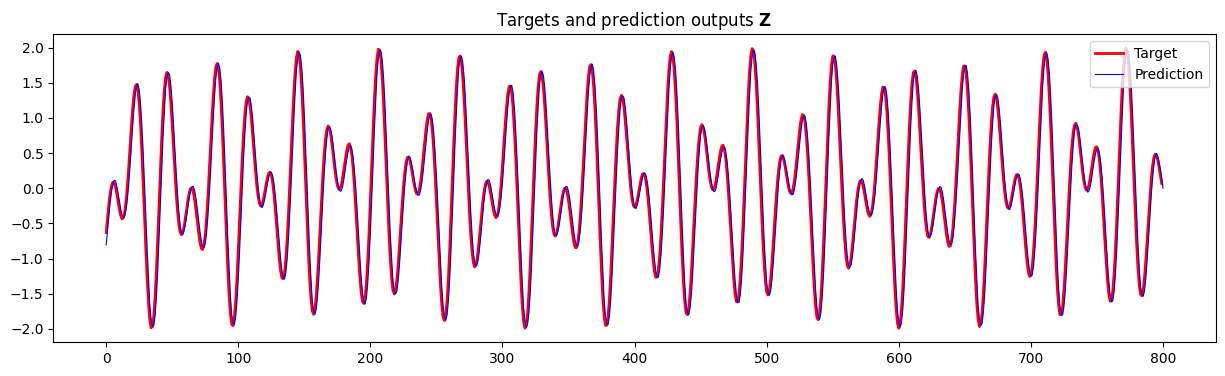

In [706]:
train_size = 20# change train_size to default
k = 1
returnList = runESN(datasetName, N_i, N_r, N_o, train_size, test_size, error_size, k, n)[:]
Z = returnList[3]
plot_testing(train_size, test_size, Z)

- k = 5

MSE = 0.0669891215600334


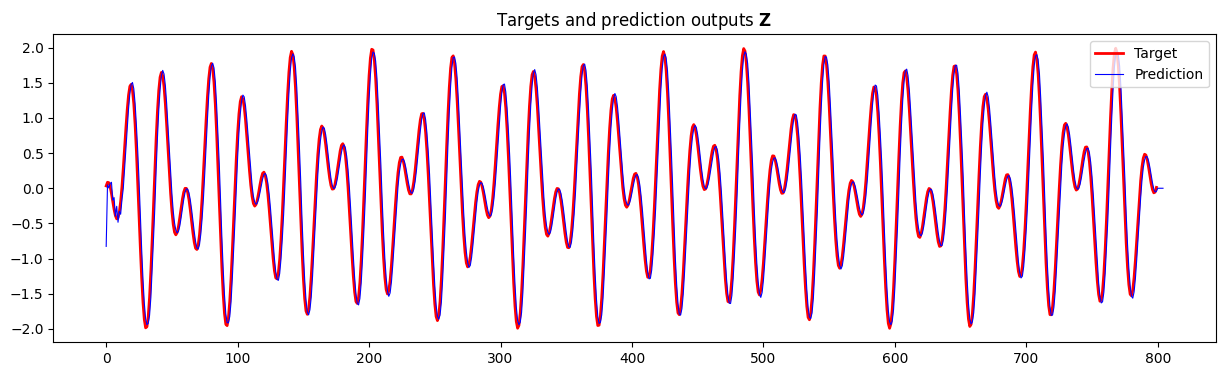

In [707]:
k = 5
returnList = runESN(datasetName, N_i, N_r, N_o, train_size, test_size, error_size, k, n)[:]
Z = returnList[3]
plot_testing(train_size, test_size, Z)

- k = 20

MSE = 0.07158182335661052


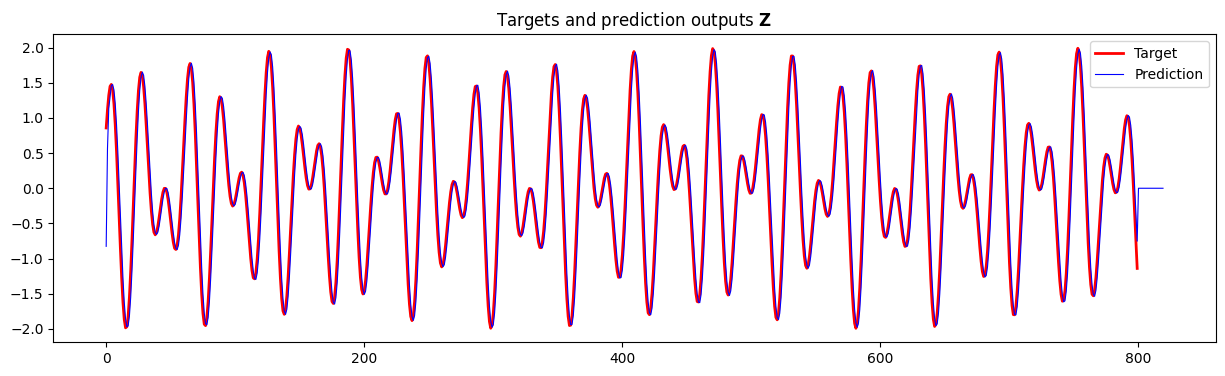

In [708]:
k = 20
returnList = runESN(datasetName, N_i, N_r, N_o, train_size, test_size, error_size, k, n)[:]
Z = returnList[3]
plot_testing(train_size, test_size, Z)

- k = 50

MSE = 0.07156072634658096


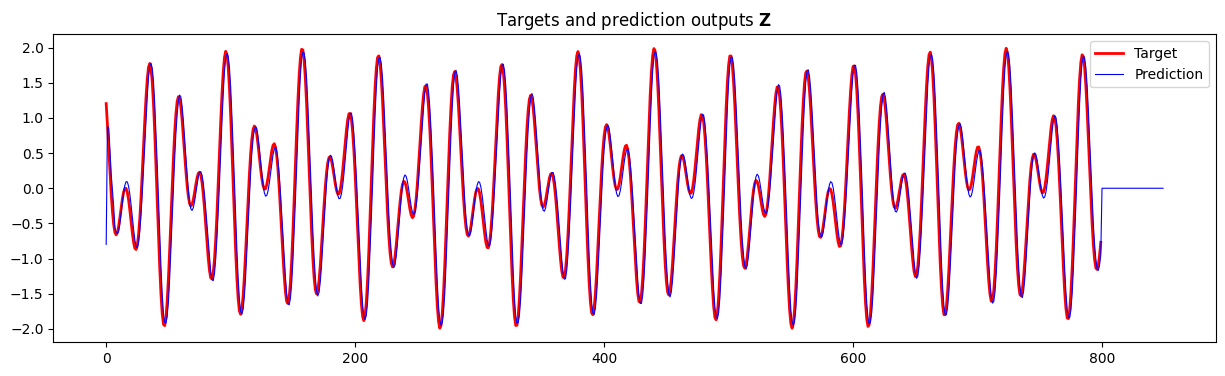

In [709]:
k = 50
returnList = runESN(datasetName, N_i, N_r, N_o, train_size, test_size, error_size, k, n)[:]
Z = returnList[3]
plot_testing(train_size, test_size, Z)

In this experiment, the prediction error increases as k continues to increase (1-5-20-50). Therefore, I consider that the size of k affects the output results.

---
#### Load "lorenz.txt", train ESN, predict output, calculate error
Default:

In [710]:
datasetName = "lorenz.txt"
N_i = 1
N_r = 10
N_o = 1
train_size = 100
test_size = 2000
error_size = 2000
k = 1
n = 0
returnList = runESN(datasetName, N_i, N_r, N_o, train_size, test_size, error_size, k, n)[:]
dataset = returnList[0]
X = returnList[1]
W_o = returnList[2]
Z = returnList[3]
mse = returnList[4]

MSE = 0.3226875515626083


#### Plot diagram
The first diagram presents the original dataset<br>
The second diagram presents targets and prediction outputs during testing process. Red line is targets, blue line is prediction outputs<br>
The third diagram presents reservoirs states<br>
The Fourth diagram presents read-out weights

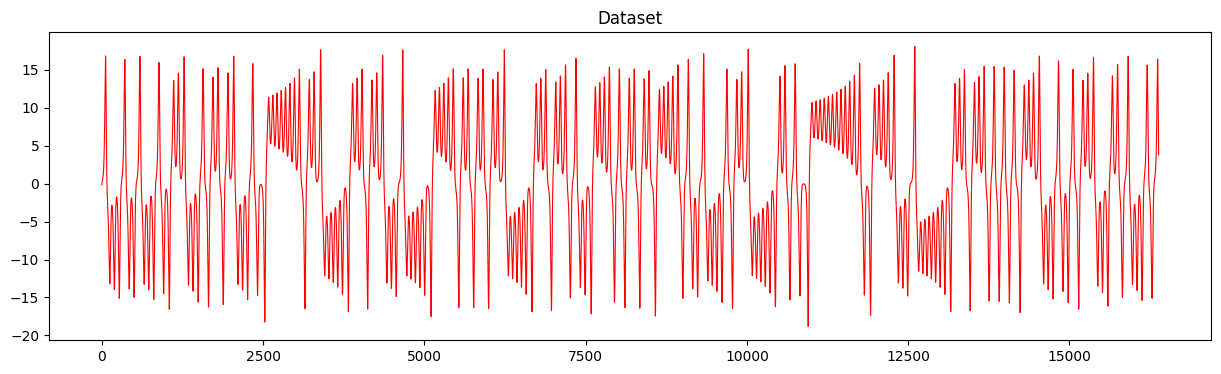

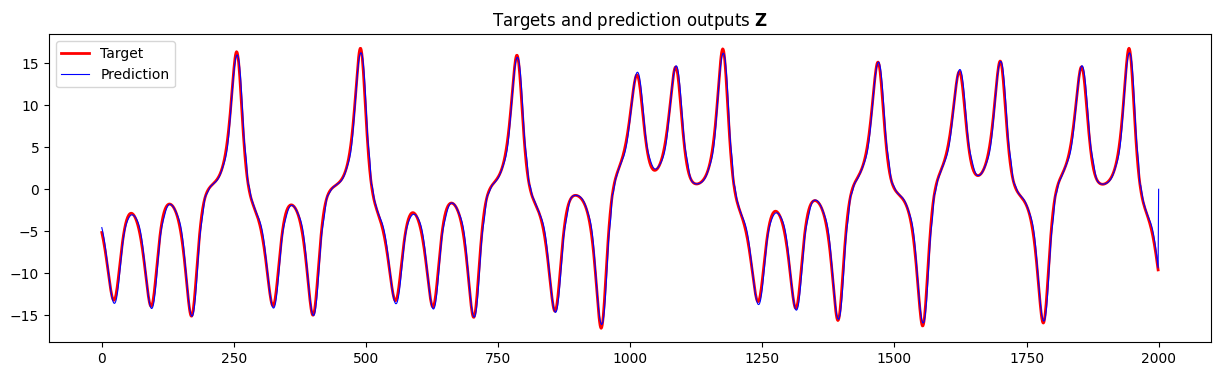

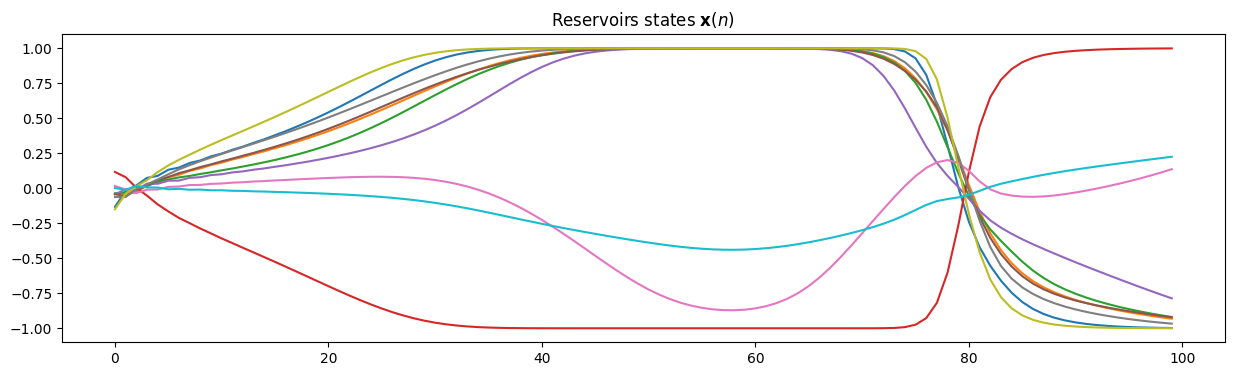

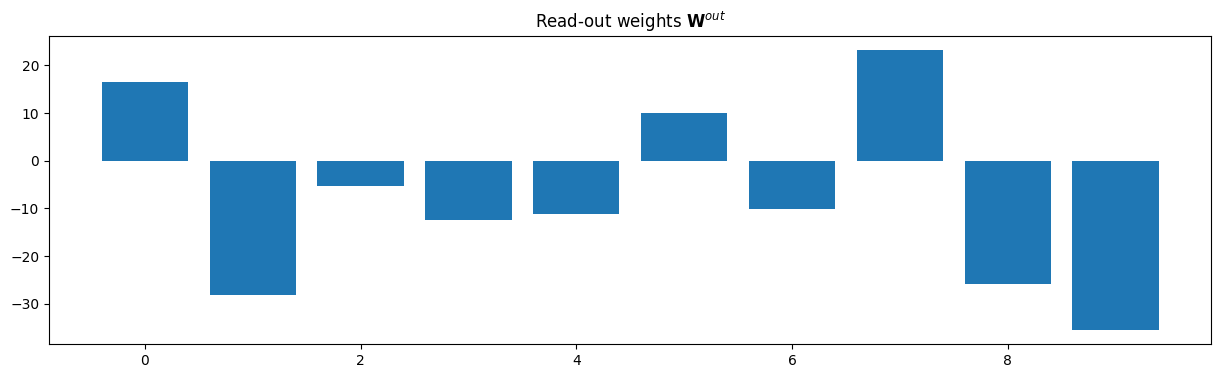

In [711]:
plot_original(dataset)
plot_testing(train_size, test_size, Z)
plot_states(X)
plot_Wo(N_r, W_o)

#### Impact of relevant hyper-parameters: reservoir size
In order to compare the effect of the number of reservoirs on the results, I will only change N_r in the following experiments<br>
- N_r = 3

MSE = 4.899035765400401


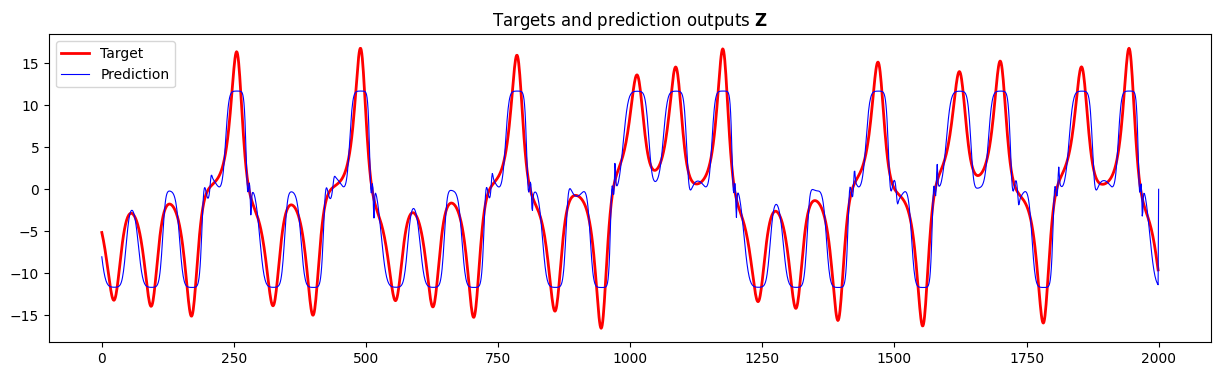

In [712]:
N_r = 3
returnList = runESN(datasetName, N_i, N_r, N_o, train_size, test_size, error_size, k, n)[:]
Z = returnList[3]
plot_testing(train_size, test_size, Z)

- N_r = 30

MSE = 0.20753078095326513


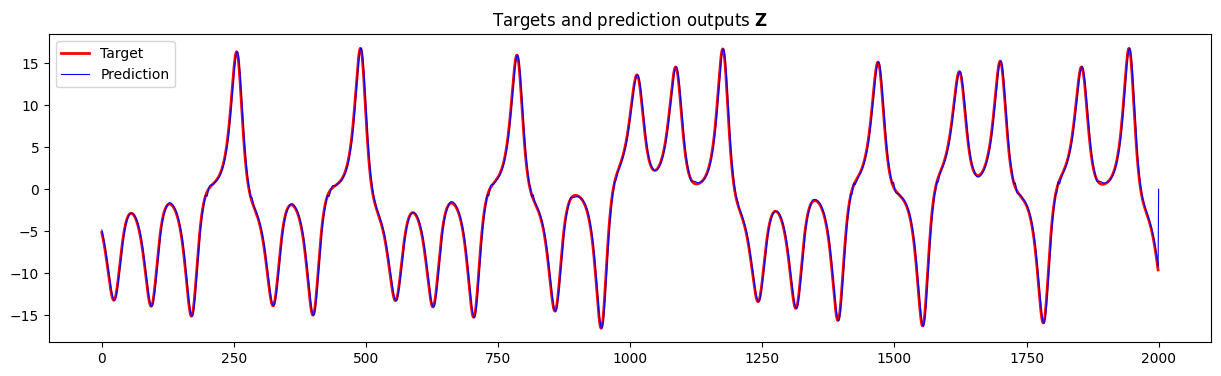

In [713]:
N_r = 30
returnList = runESN(datasetName, N_i, N_r, N_o, train_size, test_size, error_size, k, n)[:]
Z = returnList[3]
plot_testing(train_size, test_size, Z)

- N_r = 300

MSE = 0.20123969872298395


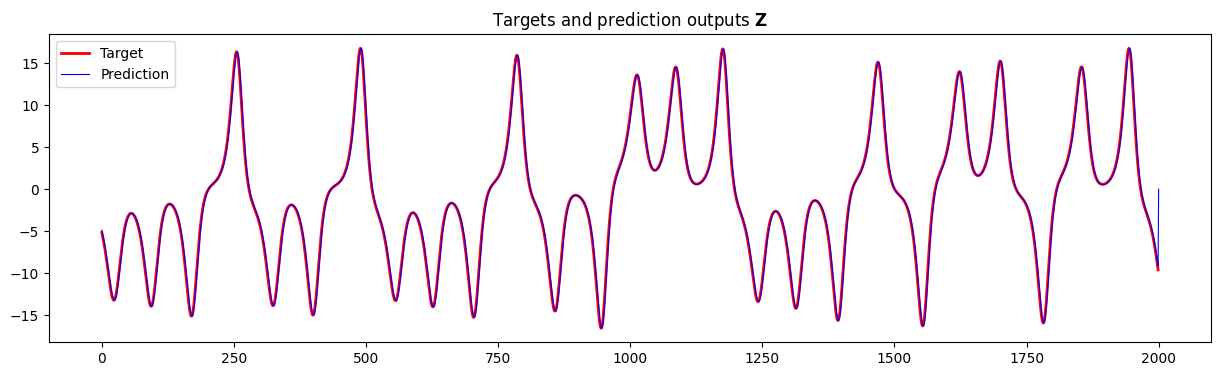

In [714]:
N_r = 300
returnList = runESN(datasetName, N_i, N_r, N_o, train_size, test_size, error_size, k, n)[:]
Z = returnList[3]
plot_testing(train_size, test_size, Z)

- N_r = 1000

MSE = 0.2052695781825956


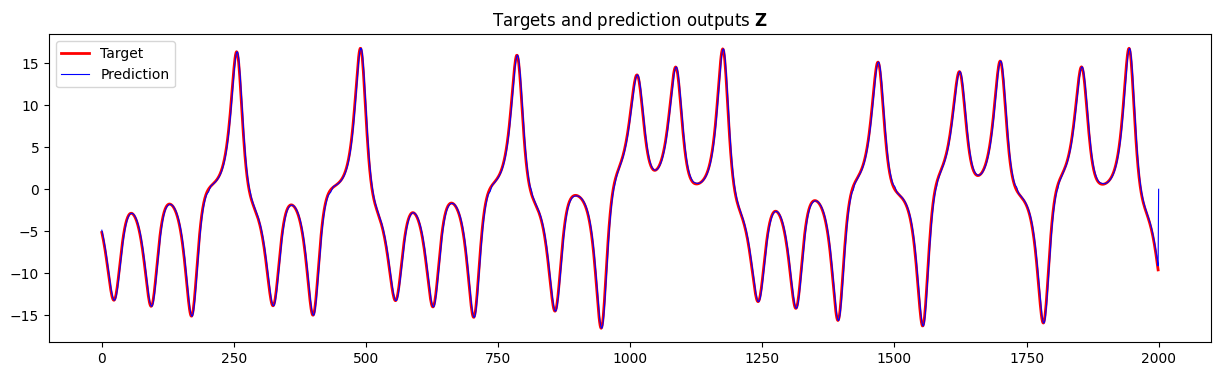

In [715]:
N_r = 1000
returnList = runESN(datasetName, N_i, N_r, N_o, train_size, test_size, error_size, k, n)[:]
Z = returnList[3]
plot_testing(train_size, test_size, Z)

In this experiment, as the number of reservoirs increases (3-30-300-1000), the prediction error becomes smaller and smaller. Therefore, I have same conclusion as "2sin.txt", i consider that an increase in the number of reservoirs will reduce the prediction error
#### Impact of relevant hyper-parameters: the amount of training data used for optimizing the read-out weights
In order to compare the effect of the amount of training data, I will only change train_size in the following experiments<br>
- train_size = 20

MSE = 34.24264875871277


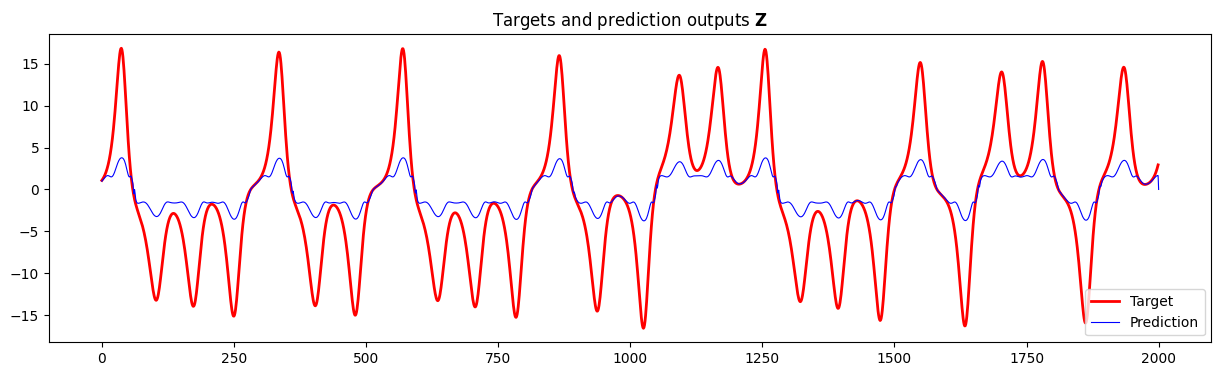

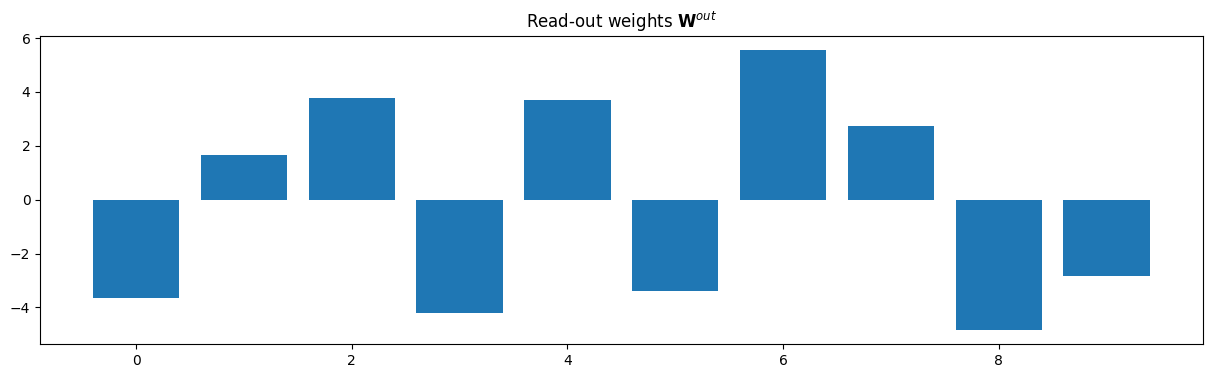

In [716]:
N_r = 10 # change N_r to default
train_size = 20
returnList = runESN(datasetName, N_i, N_r, N_o, train_size, test_size, error_size, k, n)[:]
W_o = returnList[2]
Z = returnList[3]
plot_testing(train_size, test_size, Z)
plot_Wo(N_r, W_o)

- train_size = 800

MSE = 1.9032945412061602


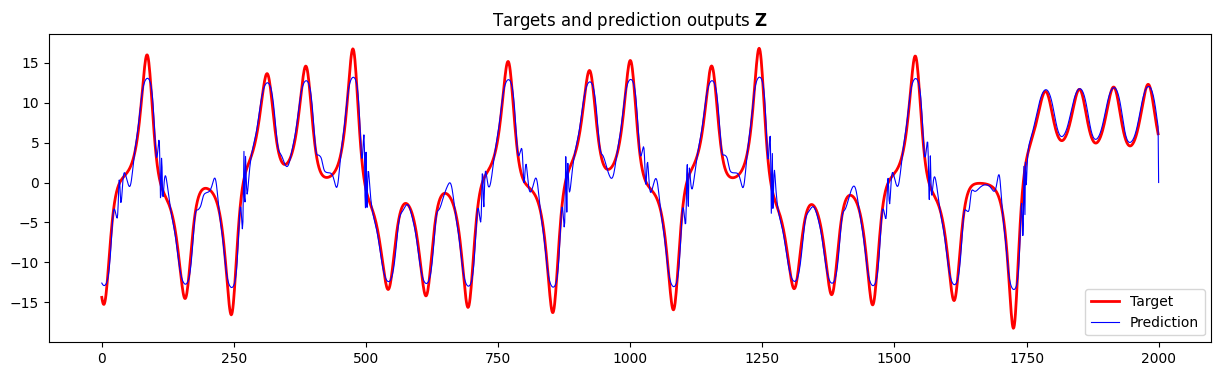

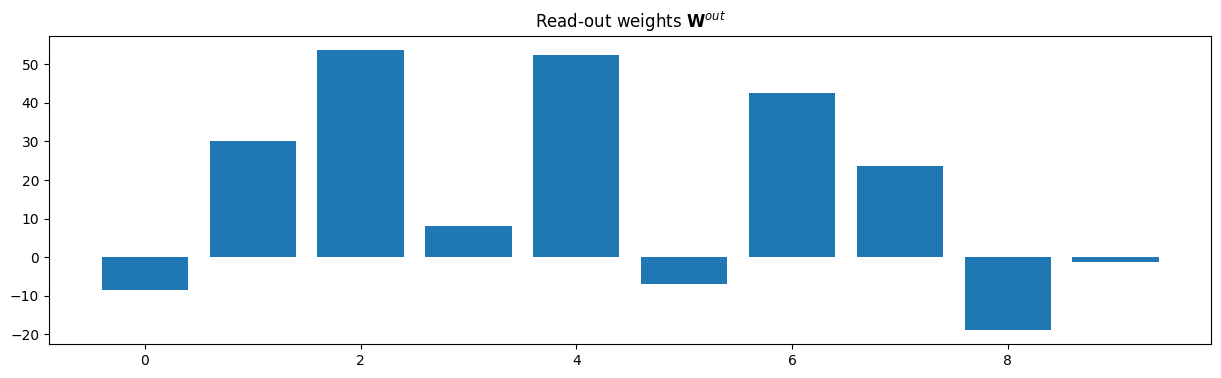

In [717]:
train_size = 800
returnList = runESN(datasetName, N_i, N_r, N_o, train_size, test_size, error_size, k, n)[:]
W_o = returnList[2]
Z = returnList[3]
plot_testing(train_size, test_size, Z)
plot_Wo(N_r, W_o)

- train_size = 1500

MSE = 0.17960424288054977


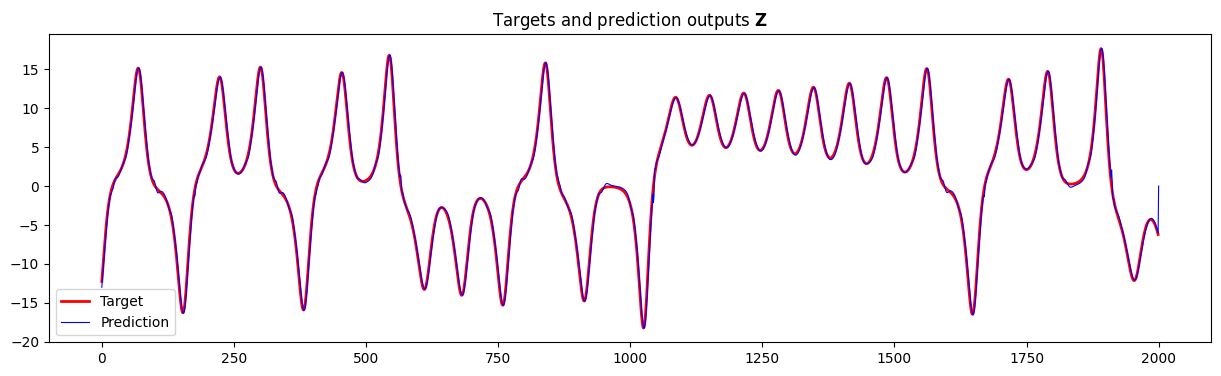

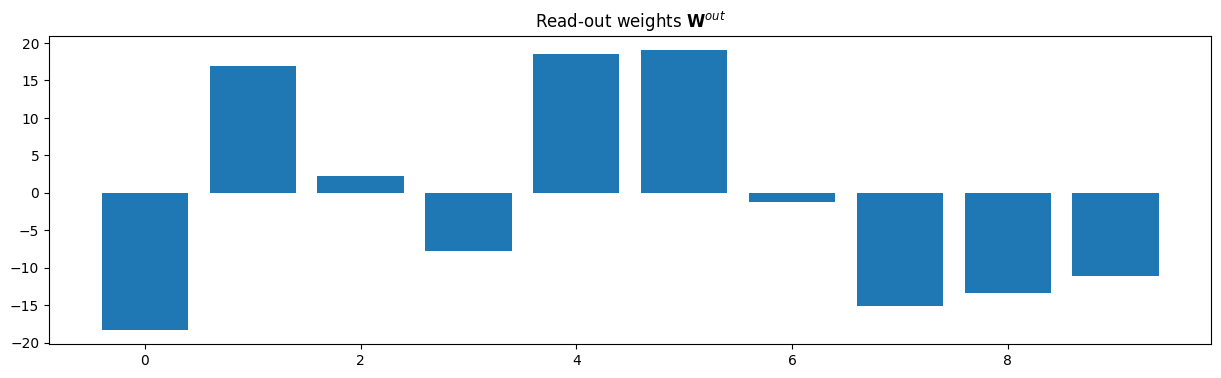

In [718]:
train_size = 1500
returnList = runESN(datasetName, N_i, N_r, N_o, train_size, test_size, error_size, k, n)[:]
W_o = returnList[2]
Z = returnList[3]
plot_testing(train_size, test_size, Z)
plot_Wo(N_r, W_o)

- train_size = 3000

MSE = 2.272733623535509


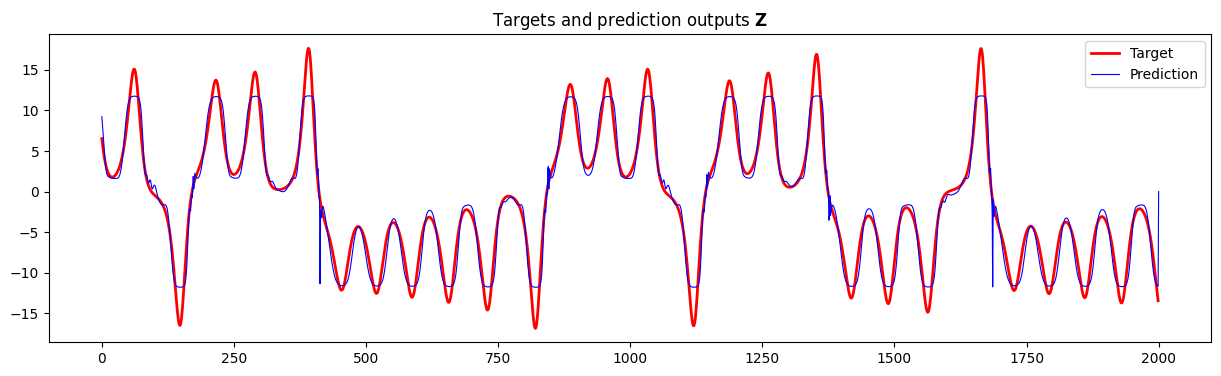

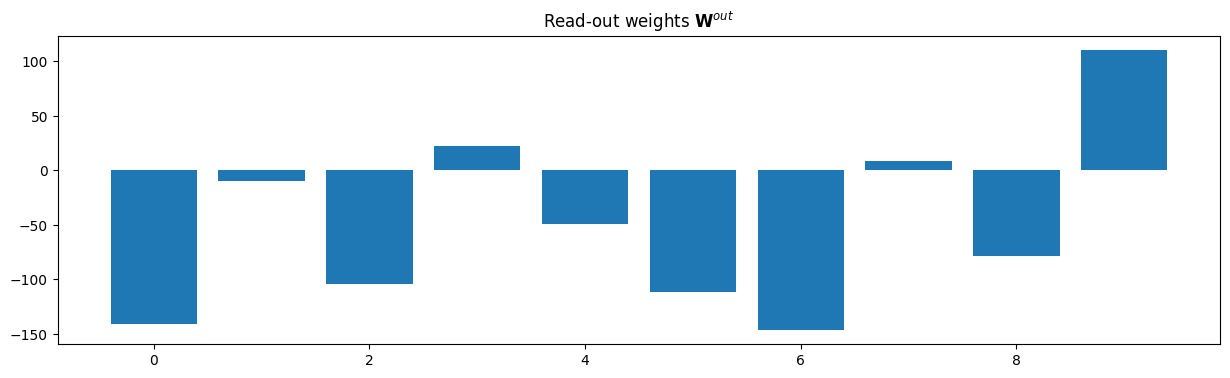

In [719]:
train_size = 3000
returnList = runESN(datasetName, N_i, N_r, N_o, train_size, test_size, error_size, k, n)[:]
W_o = returnList[2]
Z = returnList[3]
plot_testing(train_size, test_size, Z)
plot_Wo(N_r, W_o)

In this experiment, the prediction error decreases as the size of the training set increases. In particular, the prediction error decreased significantly as the size of the training set went from 20 to 800. In addition, the prediction error also maintains a decreasing trend in the training size from 800 to 1200. However, sometimes the error increases at 3000, which may be overfitting.<br>
Different sizes of the datasets used in the two experiments. Therefore for my views, increasing the size of the dataset is equivalent to increasing the size of the training set, which allows the model to not reach overfitting as quickly. Thus, the accuracy of the model can be improved and the prediction error can be reduced.

#### Impact of relevant hyper-parameters: different forecasting horizons
In order to compare the effect of different forecasting horizons, I will only change k in the following experiments
- k = 1

MSE = 0.639847770829997


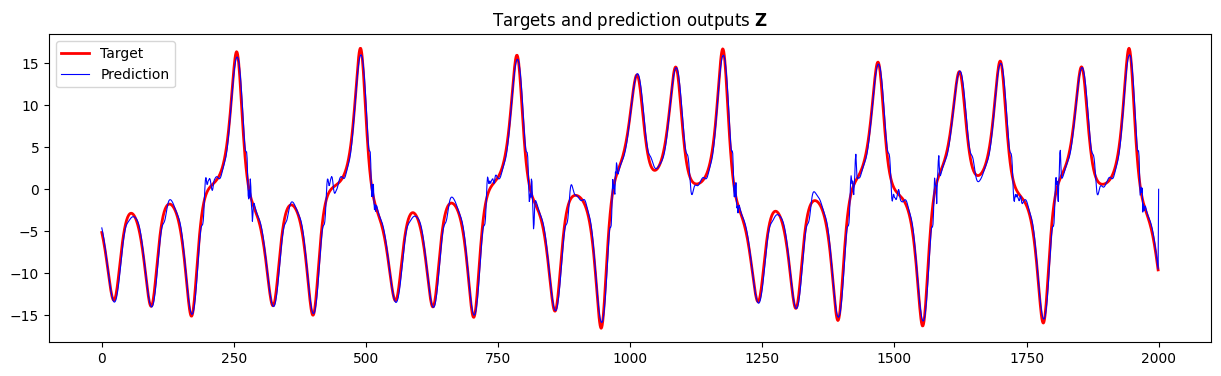

In [724]:
train_size = 100# change train_size to default
k = 1
returnList = runESN(datasetName, N_i, N_r, N_o, train_size, test_size, error_size, k, n)[:]
Z = returnList[3]
plot_testing(train_size, test_size, Z)

- k = 5

MSE = 0.26299138439308173


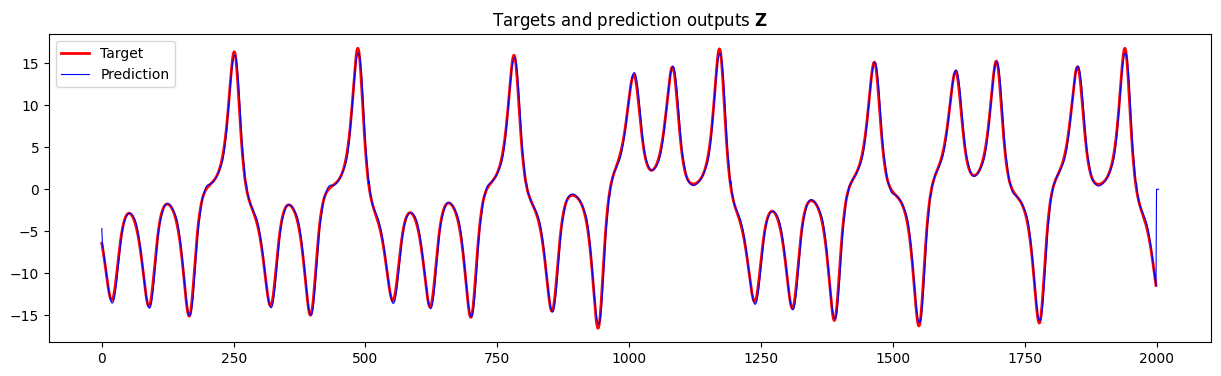

In [725]:
k = 5
returnList = runESN(datasetName, N_i, N_r, N_o, train_size, test_size, error_size, k, n)[:]
Z = returnList[3]
plot_testing(train_size, test_size, Z)

- k = 20

MSE = 2.418031576715847


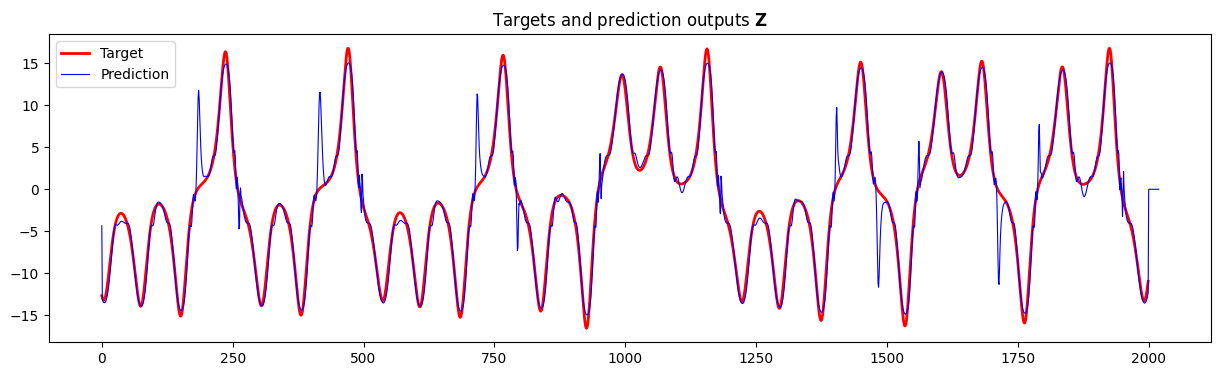

In [726]:
k = 20
returnList = runESN(datasetName, N_i, N_r, N_o, train_size, test_size, error_size, k, n)[:]
Z = returnList[3]
plot_testing(train_size, test_size, Z)

- k = 50

MSE = 0.5339515083387487


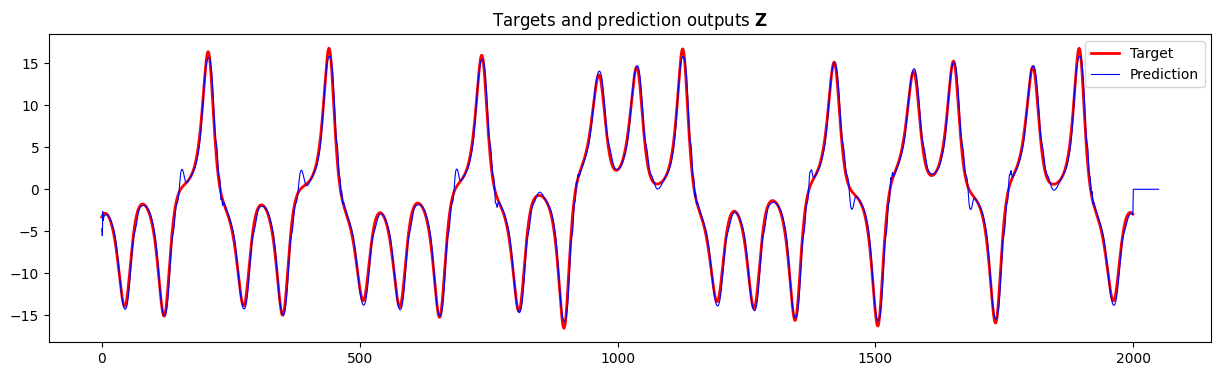

In [727]:
k = 50
returnList = runESN(datasetName, N_i, N_r, N_o, train_size, test_size, error_size, k, n)[:]
Z = returnList[3]
plot_testing(train_size, test_size, Z)

Unlike the conclusion of "2sin.txt". In Lorenz's experiment, the prediction error becomes smaller as k increases. I think this is related to the size of the data set. Larger datasets can support larger k. That's why I saw from the experiment that the error was floating with k, and even the error was decreasing as k increased.

---

This is the end of the project. Thank you for watching.